NameError: name 'prod' is not defined

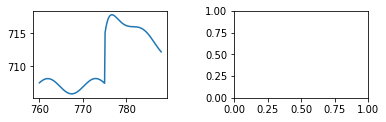

In [1]:
import matplotlib.pyplot as plt
import ticktack
import numpy as np
import jax.numpy as jnp

cbm = ticktack.load_presaved_model('Guttler14', production_rate_units='atoms/cm^2/s')
cbm.compile()



# ignore error of Warning:absl:No GPU/TPU found
start = 760
resolution = 1000
burn_in_time = np.linspace(760 - 1000, 760, resolution)
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
burn_in_solutions = cbm.equilibrate(production_rate=steady_state_burn_in)
d_14_time_series_fine = np.linspace(760, 788, 2700)
d_14_time_series_coarse = np.arange(760, 788)


def miyake_event(t, start_time, duration, phase, area):
    height = jnp.where(((t > start_time) * (t < (start_time + duration))), area / duration, steady_state_burn_in)
    prod = 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod


burn_in, _ = cbm.run(burn_in_time, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12),
                     y0=burn_in_solutions)
event, _ = cbm.run(d_14_time_series_fine, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12),
                   y0=burn_in[-1, :])
d_14_c = cbm.run_D_14_C_values(d_14_time_series_coarse, 1000, production=miyake_event,
                               args=(775, 1 / 12, np.pi / 2, 81 / 12),
                               y0=burn_in[-1, :], steady_state_solutions=burn_in_solutions)

rows = 2
columns = 2
grid = plt.GridSpec(rows, columns, wspace=0.5, hspace=0.5)
for i in range(rows * columns - 2):
    exec(f"plt.subplot(grid{[i]})")
    if i == 0:
        plt.plot(d_14_time_series_fine, event[:, 1])
    if i == 1:
        print(np.array(prod))
        plt.plot(prod)
        # plt.plot(d_14_time_series_coarse[0:-1], d_14_c, 'o')
    plt.ticklabel_format(useOffset=False)

plt.show()
